In [ ]:
%%capture
!pip install torchinfo

## Import Library

In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# os
import os

# OrderedDict
from collections import OrderedDict

# tqdm
from tqdm.auto import tqdm

# Path
from pathlib import Path

# random
import random

# typing
from typing import Dict, List

# warnings
import warnings
warnings.filterwarnings("ignore")


# Input Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from pathlib import Path

# Set the path to your data directory
IMAGE_PATH = Path("/content/drive/My Drive/files")

# Use glob to list all jpg images within the folder structure
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/**/**/*.jpg"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')




Total Images = 87


In [ ]:
# Optional: Print some paths to verify
for path in IMAGE_PATH_LIST[:10]:
    print(path)

/content/drive/My Drive/files/acne/0/right_side.jpg
/content/drive/My Drive/files/acne/0/left_side.jpg
/content/drive/My Drive/files/acne/0/front.jpg
/content/drive/My Drive/files/acne/9/front.jpg
/content/drive/My Drive/files/acne/9/right_side.jpg
/content/drive/My Drive/files/acne/9/left_side.jpg
/content/drive/My Drive/files/acne/6/left_side.jpg
/content/drive/My Drive/files/acne/6/front.jpg
/content/drive/My Drive/files/acne/6/right_side.jpg
/content/drive/My Drive/files/acne/1/right_side.jpg


In [ ]:
# number of images per class.
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 20)
print(" " * 10, f"Total Classes = {len(classes)}")
print("**" * 20)

for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    print(f"* {c}: {len(total_images_class)} images")


****************************************
           Total Classes = 4
****************************************
* .DS_Store: 0 images
* acne: 30 images
* bags: 27 images
* redness: 30 images


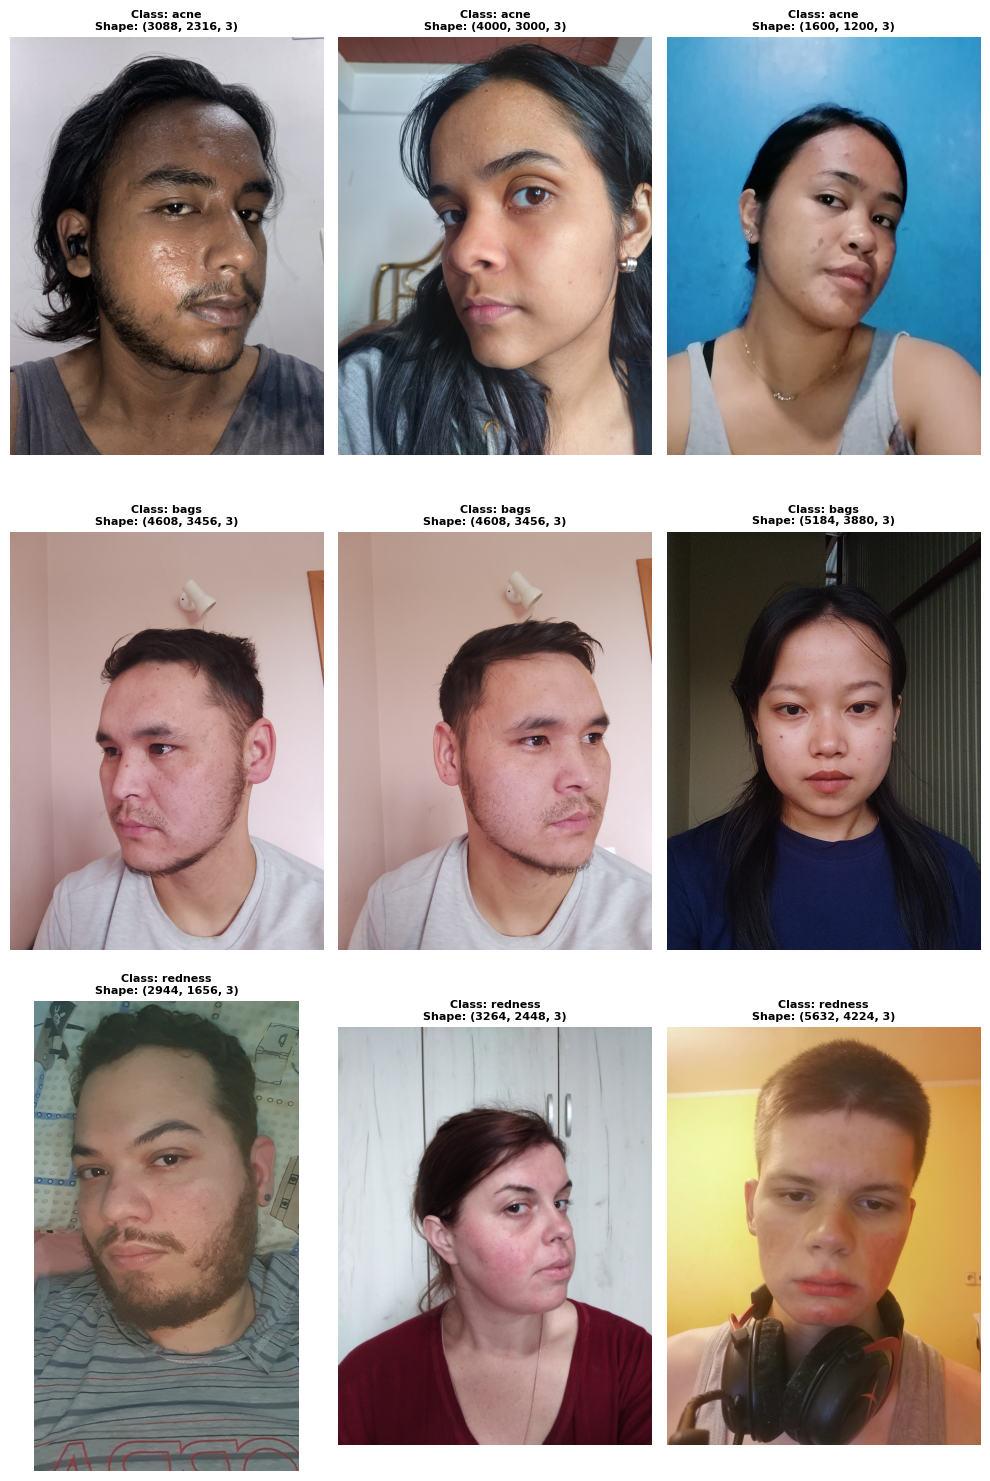

In [ ]:
# We view some images for each class.
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10,15))
p = 0
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    images_selected = random.choices(total_images_class, k = NUM_IMAGES)

    for i,img_path in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis("off")
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}", fontsize = 8, fontweight = "bold", color = "black")

    p += 1

fig.tight_layout()
fig.show()

# Preprocessing

In [ ]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,image_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = image_path
    labels[i] = image_path.parent.parent.stem

df_path_and_label = pd.DataFrame({'path':images_path,
                                  'label':labels})
df_path_and_label.head()

,path,label
0,/content/drive/My Drive/files/acne/0/right_sid...,acne
1,/content/drive/My Drive/files/acne/0/left_side...,acne
2,/content/drive/My Drive/files/acne/0/front.jpg,acne
3,/content/drive/My Drive/files/acne/9/front.jpg,acne
4,/content/drive/My Drive/files/acne/9/right_sid...,acne



train = 70%
valid = 15%
test = 15%

## Membagi dataset ke data train dan data test serta validation

In [ ]:
SEED = 123

df_train, df_rest = tts(df_path_and_label,
                        test_size = 0.3,
                        random_state = SEED,
                        stratify = df_path_and_label["label"])

df_val, df_test = tts(df_rest,
                      test_size = 0.5,
                      random_state = SEED,
                      stratify = df_rest["label"])

## Mapping dari kelas ke angka

In [ ]:
# We have to define the mapping of the classes to convert the labels to numbers.
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'acne': 0, 'bags': 1, 'redness': 2}

## Define tranformasi otomatis untuk gambar

In [ ]:
# Now we define the transformations that we are going to apply.
weights = ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## Membuat dataset dan data loaders

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transforms, label_map:dict):
        self.df = df
        self.transforms = transforms
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        df_new = self.df.copy()
        df_new = df_new.reset_index(drop = True)
        df_new["label"] = df_new["label"].map(self.label_map)
        image_path = df_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = df_new.iloc[idx, 1]

        return image,label

In [ ]:
# Create datasets
train_dataset = CustomDataset(df_train, auto_transforms, label_map)
valid_dataset = CustomDataset(df_val, auto_transforms, label_map)
test_dataset = CustomDataset(df_test, auto_transforms, label_map)


In [ ]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

## Data loader

In [ ]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)
valid_dataloader = DataLoader(dataset = valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

In [ ]:
# Let's visualize the dimensions of a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

# Model

In [ ]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# We define the model to use with the pre-trained weights.
model = vit_b_16(weights = weights)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 118MB/s]


In [ ]:
# Let's visualize the architecture of the model.
summary(model = model,
        input_size = [1, 3, 224, 224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         True
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]   [1, 1

freeze the parameters of the conv_proj and encoder layers (ini buat nyegah overfitting sama nyepetin pelatihan gt kubaca)

In [ ]:
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
# Let's see if the parameters were frozen.
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

parameters were frozen.

Let's visualize the last layer which we will modify the number of out_features, in this case it is the number of classes we have.

In [ ]:
output_shape = len(classes)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768,
                                                            out_features = output_shape))]))

In [ ]:
# One last time let's take a look if the last layer was modified.
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

define the loss function and the optimizer.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

define 3 functions for training and one to store the best model:

1. train_step
2. save_checkpoint
3. valid_step
4. train

In [ ]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    train_accuracy = 0.

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(),
                                         y_pred_class.detach().cpu().numpy())

    train_loss = train_loss/len(dataloader)
    train_accuracy = train_accuracy/len(dataloader)

    return train_loss, train_accuracy

In [ ]:
def save_checkpoint(filename, model, loss, epoch, optimizer, metric):
    state = {"filename":filename,
             "model":model.state_dict(),
             "loss":loss,
             "epoch":epoch,
             "optimizer":optimizer.state_dict(),
             "metric":metric}

    torch.save(state, filename)

In [ ]:
def valid_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module):

    model.eval()

    valid_loss = 0.
    valid_accuracy = 0.

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()

            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)

            valid_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
            valid_loss = valid_loss/len(dataloader)
    valid_accuracy = valid_accuracy/len(dataloader)

    return valid_loss, valid_accuracy

In [ ]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          valid_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epochs:int = 10):

    results = {"train_loss":[],
               "train_accuracy":[],
               "valid_loss":[],
               "valid_accuracy":[]}

    best_valid_loss = float("inf")

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                                dataloader = train_dataloader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer)
        valid_loss, valid_accuracy = valid_step(model = model,
                                                dataloader = valid_dataloader,
                                                loss_fn = loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)

        print(f"Epoch: {epoch + 1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Valid Loss: {valid_loss:.4f} | ",
              f"Valid Accuracy: {valid_accuracy:.4f}")

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)

    return results

In [ ]:
# Training!!!
EPOCHS = 100

torch.manual_seed(SEED)

MODEL_RESULTS = train(model,
                      train_dataloader,
                      valid_dataloader,
                      loss_fn,
                      optimizer,
                      EPOCHS)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 1.6440 |  Train Accuracy: 0.6167 |  Valid Loss: 0.5418 |  Valid Accuracy: 0.4615
Epoch: 2 |  Train Loss: 0.9107 |  Train Accuracy: 0.6667 |  Valid Loss: 0.0079 |  Valid Accuracy: 0.6154
Epoch: 3 |  Train Loss: 1.7664 |  Train Accuracy: 0.7333 |  Valid Loss: 0.0032 |  Valid Accuracy: 0.9231
Epoch: 4 |  Train Loss: 0.6205 |  Train Accuracy: 0.8333 |  Valid Loss: 0.0063 |  Valid Accuracy: 1.0000
Epoch: 5 |  Train Loss: 0.0382 |  Train Accuracy: 0.9833 |  Valid Loss: 0.0007 |  Valid Accuracy: 1.0000
Epoch: 6 |  Train Loss: 0.0031 |  Train Accuracy: 1.0000 |  Valid Loss: 0.0001 |  Valid Accuracy: 1.0000
Epoch: 7 |  Train Loss: 0.0019 |  Train Accuracy: 1.0000 |  Valid Loss: 0.0002 |  Valid Accuracy: 1.0000
Epoch: 8 |  Train Loss: 0.0017 |  Train Accuracy: 1.0000 |  Valid Loss: 0.0002 |  Valid Accuracy: 1.0000
Epoch: 9 |  Train Loss: 0.0015 |  Train Accuracy: 1.0000 |  Valid Loss: 0.0004 |  Valid Accuracy: 1.0000
Epoch: 10 |  Train Loss: 0.0014 |  Train Accuracy: 1.00

In [ ]:
# Function to plot the loss and metric during each training epoch.
def loss_metric_curve_plot(model_results:Dict[str,List[float]]):

    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]

    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]

    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    axes = axes.flat

    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(valid_loss, color = "blue", label = "Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()

    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(valid_accuracy, color = "blue", label = "Valid")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()

    fig.tight_layout()
    fig.show()

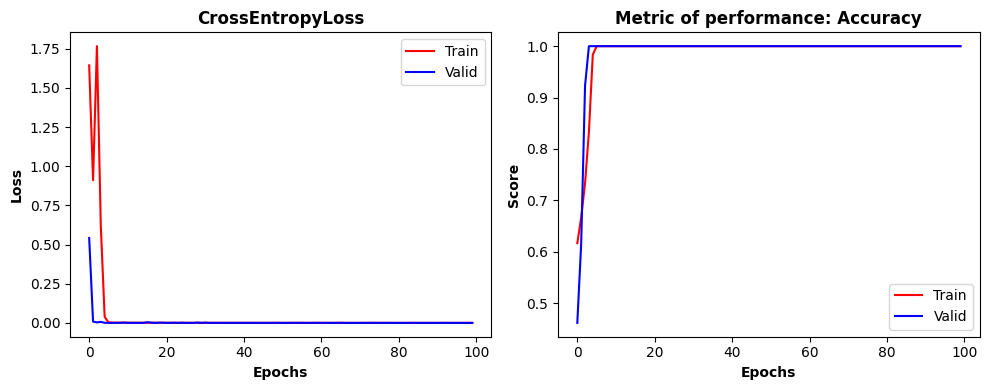

In [ ]:
loss_metric_curve_plot(MODEL_RESULTS)

In [ ]:
# Mengubah jalur file untuk Google Colab
checkpoint_path = "/content/best_model.pth"
checkpoint = torch.load(checkpoint_path)

In [ ]:
# Now let's look at the smallest loss, its metric and when it occurred.
print(f'Best Loss: {checkpoint["loss"]}')
print(f'Epoch: {checkpoint["epoch"] + 1}')
print(f'Best Metric: {checkpoint["metric"]}')

Best Loss: 7.239539509123486e-07
Epoch: 97
Best Metric: 1.0


## Prediction

In [ ]:
# First of all, we create the Dataset, DataLoader
test_dataset = CustomDataset(df_test, auto_transforms, label_map)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = False, num_workers = NUM_WORKERS)

In [ ]:
# We define the model again with its respective modification.
loaded_model = vit_b_16()

loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768,
                                                                  out_features = output_shape))]))

loaded_model.load_state_dict(checkpoint["model"])

# We now infer
loaded_model.to(device)

loaded_model.eval()

y_pred_test = []

with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        y_pred_test.append(y_pred_class.detach().cpu())

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
y_pred_test = torch.cat(y_pred_test).numpy()

## Metrics

### Acuracy

In [ ]:
print(f'Accuracy = {round(accuracy_score(df_test["label"].map(label_map), y_pred_test), 4)}')

Accuracy = 0.8571


### Confusion Matrix

In [ ]:
confusion_matrix_test = confusion_matrix(df_test["label"].map(label_map), y_pred_test)

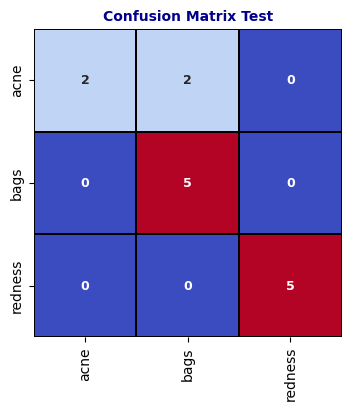

In [ ]:
fig,ax = plt.subplots(figsize = (15,4))
sns.heatmap(confusion_matrix_test,
            cmap = 'coolwarm',
            annot = True,
            annot_kws = {"fontsize":9, "fontweight":"bold"},
            linewidths = 1.2,
            linecolor = "black",
            square = True,
            xticklabels = classes,
            yticklabels = classes,
            cbar = False,
            ax = ax)
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "darkblue")
ax.tick_params('x',rotation = 90)
fig.show()